In [36]:
import requests
import pandas as pd
from io import StringIO
import matplotlib.pyplot as plt
import datetime

# Download DATA

In this section we choose which time series we want to download from the CNB ARAD time series system (A public database that is part of the information service of the Czech National Bank. The system presents aggregated data for individual statistics and areas of the financial market in a uniform manner in time series.)

#### ARAD codes - legend

*   SHDPZDRQ20152B1GMIRSA - GDP Index, 2015 = 100, S.A.
*   SHDPVYDQ20152B1GNMLSA - GDP volume, constant prices, CZK MIL, S.A.
*   SHDPVYDQ20151B1GNISNA - GDP Index y-o-y, current prices, not-adjusted
*   SPRUMMIR20151SA - Industry production Index, 2015 = 100, S.A.
*   SPRUMMIS20151NA - Industry production y-o-y Index, not-adjusted
*   SCCSUM2005IR00 - CPI Index until 2016, 2005=100
*   SCCSUM2015IR00 - CPI Index from 2017, 2015=100
*   SCCSUM2005IS00 - CPI Index y-o-y until 2016
*   SCCSUM2015IS00 - CPI Index y-o-y from 2017
*   SCCSUM2015IK00 - Inflation rate y-o-y
*   MIRFMSPR3XRATPECD - 3M Pribor (daily)
*   MIRFMSPR12RATPECD - 12M Pribor (daily)
*   MEXRHCZEUQNAJEXRVALNOMQ - Exchange rate EUR/CZK (quarterly), hedging of exports

In the ID_dict dictionary, the key is a CNB ARAD indicator_id and the value is a descrtiption of the indicator. Above, more detailed description of each time series based on the indicator_id is given. Under my_api_key is the individual's API key which can be created on the CNB ARAD website after registration.

In [37]:
#Define variables and login
ID_dict = {"SHDPZDRQ20152B1GMIRSA": 'GDP_index', 'SHDPVYDQ20152B1GNMLSA': 'GDP_vol', 'SHDPVYDQ20151B1GNISNA': 'GDP_yoy', "SPRUMMIR20151SA":"Industry_index",
           'SCCSUM2005IR00': 'CPI_index_2016',"SCCSUM2015IR00":"CPI_index_2017" ,'SCCSUM2005IS00': 'CPI_yoy_2016','SCCSUM2015IS00': 'CPI_yoy_2017',
          'MIRFMSPR3XRATPECD': 'PRIBOR_3M', 'MIRFMSPR12RATPECD': 'PRIBOR_12M', 'MEXRHCZEUQNAJEXRVALNOMQ': 'EUR_CZK'}

my_IDs = ','.join(ID_dict.keys())
my_api_key = "202326111959266710376710375FTR2ZOFR7GADZLV"

In [40]:
def download_data_from_api(api_key, indicator_ids):
  '''
  Downloads time series data from the CNB ARAD database on the indicators given to it in the indicator_ids as one string separated by commas without space. Individual's API key
  which can be created on the CNB ARAD website after registration. The output is in the data frame format with columns: index, indicator_id, period (YYYY-MM-DD), value.
  '''
  url = f'https://www.cnb.cz/aradb/api/v1/data?indicator_id_list={indicator_ids}&api_key={api_key}'
  response = requests.get(url)
  data=response.text
  if response.status_code == 200:
      df = pd.read_csv(StringIO(data), delimiter=';', decimal=',', thousands=None)

      df['period'] = pd.to_datetime(df['period'], format='%Y%m%d')

      df = df.drop(columns="snapshot_id")

      return df
  else:
      print("Failed to fetch data from the API")
      return None

In [41]:
#Download data
my_df = download_data_from_api(my_api_key, my_IDs)
if my_df is not None:
    print(my_df)

                  indicator_id     period       value
0        SHDPZDRQ20152B1GMIRSA 2023-09-30   99.206971
1        SHDPZDRQ20152B1GMIRSA 2023-06-30   99.608377
2        SHDPZDRQ20152B1GMIRSA 2023-03-31   99.684361
3        SHDPZDRQ20152B1GMIRSA 2022-12-31  100.145524
4        SHDPZDRQ20152B1GMIRSA 2022-09-30  101.339006
...                        ...        ...         ...
10775  MEXRHCZEUQNAJEXRVALNOMQ 1999-03-31   37.156000
10776  MEXRHCZEUQNAJEXRVALNOMQ 1998-12-31   35.124000
10777  MEXRHCZEUQNAJEXRVALNOMQ 1998-09-30   35.321000
10778  MEXRHCZEUQNAJEXRVALNOMQ 1998-06-30   36.579000
10779  MEXRHCZEUQNAJEXRVALNOMQ 1998-03-31   37.664000

[10780 rows x 3 columns]


In [42]:
#Check if all requested time series are downloaded
if set(ID_dict) == set(my_df["indicator_id"]):
  print("All requested series downloaded successfully")
else:
  print("Some requested series are missing")

All requested series downloaded successfully


# Processing the data

In this section we define a series of functions for processing and manipulating a pandas DataFrame containing our time series indicators.

In [43]:
def process_data(my_df, ID_dict):
  '''
  Adds a new column "year_month" to the DataFrame, extracts monthly data based on the "indicator_id" and "year_month,"
  pivots the table, renames columns according to the provided dictionary, and returns the processed DataFrame.
  '''
  my_df['year_month'] = my_df['period'].dt.to_period('M')

  monthly_df = my_df.groupby(['indicator_id', 'year_month']).mean().reset_index()

  monthly_df = pd.pivot(monthly_df, index="year_month", columns="indicator_id", values="value")

  monthly_df.rename(columns=ID_dict, inplace=True)

  return monthly_df


In [44]:
def data_to_current_date(df):
  '''
  Calculates the current year and month, subsets the DataFrame up to the current year and month, and returns the updated DataFrame.
  '''
  ct = datetime.datetime.now()
  current_year_month = ct.strftime("%Y-%m")
  df = df[:current_year_month]

  return df

In [45]:
def recalculate_series_to_differente_base(df,column_recalculate, column_contains_base_year, base_year):
  '''
  Normalizes the specified column based on the mean value of the base year and returns the updated DataFrame.

  Provide a pandas data frame with index in a date format, and two columns, which are part of one index, but with a different base or one column, but you want to recalculate
  it to a different base year. In the latter case, insert the same column name twice. Provide the base year and the function recalculates the column_recalculate to the
  designated base.
  '''
  df['year'] = df.index.year

  base_year_df = df[df['year'] == base_year].copy()
  base_mean = base_year_df[column_contains_base_year].mean()

  df[column_recalculate] = df[column_recalculate].apply(lambda x: x * 100 / base_mean)

  return df

In [46]:
def combine_consecutive_series(df,column1,column2,partition_year, name_new_column):
  '''
  Combines the consecutive series based on the partition year and returns the updated DataFrame with new combined column named according to specification in the
  name_new_column argument.

  Provide a pandas data frame with index in a date format, and two columns, which are part of one series, one ending on a specific date and the other continuing from the following
  date. Provide the year (partition_year) when the first part of the series (column1) ends. Finally provide the name of the new combined column (name_new_column).
  '''
  df['year'] = df.index.year

  df[name_new_column] = df.apply(lambda row: row[column1] if row['year'] <= partition_year else row[column2], axis=1)
  df = df.drop([column1, column2], axis=1)

  return df

In [47]:
def growth_from_yoy_index(df,yoy_index_column,new_growth_column):
  '''
  Calculates the growth from the year-over-year index and adds a new column for growth named according to specification in the new_growth_column argument.
  '''
  df[new_growth_column]=df_combed[yoy_index_column].apply(lambda a: a -100)
  return df

In [48]:
def growth_from_index(df,index_column,new_growth_column):
  '''
  Calculates the percentage growth from the index and adds a new column for growth named according to specification in the new_growth_column argument.
  '''
  df[new_growth_column] = df_combed[index_column].pct_change() * 100
  return df

In [49]:
def backward_fill_quarterly_data(df, start_date, columns):
  '''
  Subsets the DataFrame from the start date, backward fills the specified columns, and returns the updated DataFrame.

  Provide a data frame with a date type index, column, or list of columns you want to backward fill (eg. quarterly data to monthly data) and start_date from which you want
  to start the filling.
  '''
  temp_df = df.copy()
  temp_df = temp_df.loc[start_date:]
  temp_df[columns] = temp_df[columns].fillna(method='bfill')
  df = df.combine_first(temp_df)

  return df

In [50]:
def subset_df(df, columns):
  '''
  Subsets the DataFrame to include only the specified columns in the columns argument and returns the new DataFrame.
  '''
  df_sub=df.copy()
  df_sub=df_sub.filter(columns)
  return df_sub

In [51]:
def generate_desc_stats(df, columns_to_drop):
  '''
  Takes a DataFrame, drops a specific column (columns_to_drop in the list format), calculates descriptive statistics for the remaining numeric columns,
  formats the result, and returns the formatted statistics DataFrame.
  '''
  df_desc = df.drop(columns=columns_to_drop)
  desc_stats = df_desc.describe().loc[["mean", "std", "min", "25%", "50%", "75%", "max"]]
  desc_stats = desc_stats.applymap(lambda x: f"%.2f" % x)
  return desc_stats

After defining all functions, the we apply them to a DataFrame (df_combed). It processes the data by recalculating and combining series, calculating growth, filling missing values, and dividing the dataset into two subsets (df_index and df_growth) based on the nature of the data. Finally, it generates descriptive statistics for the remaining DataFrame (df_desc).

In [52]:
#Process data
df_combed = process_data(my_df, ID_dict)
df_combed =recalculate_series_to_differente_base(df_combed,"CPI_index_2016", "CPI_index_2016", 2015)
df_combed = combine_consecutive_series(df_combed,"CPI_index_2016","CPI_index_2017",2016, "CPI_index")
df_combed = combine_consecutive_series(df_combed,"CPI_yoy_2016","CPI_yoy_2017",2016, "CPI_yoy")
df_combed = growth_from_yoy_index(df_combed,"CPI_yoy","Inflation_yoy")
df_combed = growth_from_yoy_index(df_combed,"GDP_yoy","GDP_growth")
df_combed = growth_from_index(df_combed,"Industry_index","Industry_growth")
df_combed = data_to_current_date(df_combed)
df_combed

indicator_id,EUR_CZK,PRIBOR_12M,PRIBOR_3M,GDP_yoy,GDP_vol,GDP_index,Industry_index,year,CPI_index,CPI_yoy,Inflation_yoy,GDP_growth,Industry_growth
year_month,,,,,,,,,,,,,
1995-03,NaN,NaN,NaN,NaN,6.964040e+11,NaN,NaN,1995,NaN,NaN,NaN,NaN,NaN
1995-06,NaN,NaN,NaN,NaN,7.095840e+11,NaN,NaN,1995,NaN,NaN,NaN,NaN,NaN
1995-09,NaN,NaN,NaN,NaN,7.185180e+11,NaN,NaN,1995,NaN,NaN,NaN,NaN,NaN
1995-12,NaN,NaN,NaN,NaN,7.236810e+11,NaN,NaN,1995,NaN,NaN,NaN,NaN,NaN
1996-03,NaN,NaN,NaN,116.569044,7.367040e+11,105.786871,NaN,1996,NaN,NaN,NaN,16.569044,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08,NaN,6.947391,7.103043,NaN,NaN,NaN,113.0,2023,149.1,108.5,8.5,NaN,-0.176678
2023-09,24.133667,6.847000,7.089500,106.291954,1.317540e+12,99.206971,111.6,2023,148.0,106.9,6.9,6.291954,-1.238938
2023-10,NaN,6.609091,7.047273,NaN,NaN,NaN,114.7,2023,148.1,108.5,8.5,NaN,2.777778


In [53]:
#Backward Fill in the quarterly data
quarterly_columns = ["GDP_yoy", "GDP_vol", "GDP_index", "GDP_growth"]
df_combed = backward_fill_quarterly_data(df_combed, '1996-03', quarterly_columns)
df_combed = backward_fill_quarterly_data(df_combed, '1998-03', "EUR_CZK")
df_combed

indicator_id,EUR_CZK,PRIBOR_12M,PRIBOR_3M,GDP_yoy,GDP_vol,GDP_index,Industry_index,year,CPI_index,CPI_yoy,Inflation_yoy,GDP_growth,Industry_growth
year_month,,,,,,,,,,,,,
1995-03,NaN,NaN,NaN,NaN,6.964040e+11,NaN,NaN,1995,NaN,NaN,NaN,NaN,NaN
1995-06,NaN,NaN,NaN,NaN,7.095840e+11,NaN,NaN,1995,NaN,NaN,NaN,NaN,NaN
1995-09,NaN,NaN,NaN,NaN,7.185180e+11,NaN,NaN,1995,NaN,NaN,NaN,NaN,NaN
1995-12,NaN,NaN,NaN,NaN,7.236810e+11,NaN,NaN,1995,NaN,NaN,NaN,NaN,NaN
1996-03,NaN,NaN,NaN,116.569044,7.367040e+11,105.786871,NaN,1996,NaN,NaN,NaN,16.569044,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08,24.133667,6.947391,7.103043,106.291954,1.317540e+12,99.206971,113.0,2023,149.1,108.5,8.5,6.291954,-0.176678
2023-09,24.133667,6.847000,7.089500,106.291954,1.317540e+12,99.206971,111.6,2023,148.0,106.9,6.9,6.291954,-1.238938
2023-10,24.600000,6.609091,7.047273,NaN,NaN,NaN,114.7,2023,148.1,108.5,8.5,NaN,2.777778


In [54]:
#Divide the data set into time series in percentages and time series as an index with 2015=100
list_index=["CPI_index","GDP_index","Industry_index","EUR_CZK"]
df_index=subset_df(df_combed, list_index)

list_growth=["EUR_CZK","PRIBOR_12M","PRIBOR_3M","Inflation_yoy","GDP_growth","Industry_growth"]
df_growth=subset_df(df_combed, list_growth)

In [55]:
#Generates descriptive statistics (mean, standard deviation, minimum, quartiles and maximum) for all time series
desc_stats=generate_desc_stats(df_combed, ["year"])
desc_stats

indicator_id,EUR_CZK,PRIBOR_12M,PRIBOR_3M,GDP_yoy,GDP_vol,GDP_index,Industry_index,CPI_index,CPI_yoy,Inflation_yoy,GDP_growth,Industry_growth
mean,27.85,2.20,1.94,105.32,1059607177049.18,102.43,93.72,96.88,103.24,3.24,5.32,0.23
std,3.39,1.87,1.90,3.88,187647598878.60,3.24,15.37,17.87,3.50,3.50,3.88,2.76
min,23.58,0.43,0.28,93.07,696404000000.00,89.20,65.40,71.63,99.60,-0.40,-6.93,-24.12
25%,25.56,0.61,0.41,102.69,885925000000.00,100.81,81.70,82.33,101.30,1.30,2.69,-0.93
50%,26.83,1.80,1.23,105.78,1073973000000.00,102.81,93.30,96.59,102.40,2.40,5.78,0.18
75%,29.76,2.78,2.46,107.82,1218009000000.00,104.65,110.15,104.03,103.60,3.60,7.82,1.44
max,37.66,7.55,7.30,116.57,1338953000000.00,109.18,117.80,149.10,118.00,18.00,16.57,18.21


We can see that the long run average of PRIBOR yearly rate is around 2%, which corresponds to the inflation target of 2%. That would imply that the natural rate of interest provided that inflation averages at 3.2% is negative. This has to be taken with the caviat that the standard deviation of inflation is relatively large, in absolute terms than the mean inflation itself.

When we compare the two alternative matrics for performance of the economy, the GDP and Industry index, we can conclude that the latter is much more volatile, with standard deviation of it being almost five times as large. However, when we transform these series into percentage growths, the volatility of these metrics is now more relatively balanced, with the standard deviation of industry growth being even smaller than that of GDP growth.

# Visualisation
In this section we define a function visualize_ts for creating time series visualizations using Plotly Express. It is then applied to two different DataFrames (df_index and df_growth) to generate and display line plots with interactive features. The dropdown menu allows users to show or hide individual time series in the plot.

In [19]:
#!pip install dash
import pandas as pd
import plotly.express as px

In [56]:
def visualize_ts(df,index_column,graph_name):
  '''
  Uses Plotly Express to create a line plot and sets all traces to be initially hidden in the legend. It further adds a dropdown menu to toggle the visibility of traces
  (show all or hide all). Then it returns the Plotly figure object.

  Insert DataFrame (df) to be visualized. Name of the column (index_column) to be used as the x-axis (converted to string format) and insert the tittle of the graph (graph_name).
  '''
  df[index_column] = df.index.astype(str)
  fig = px.line(df, x=index_column, y=df.columns, title=graph_name, labels={index_column: 'Year-Month'})

  for trace in fig.data:
      trace.update(visible='legendonly')

  fig.update_layout(
      updatemenus=[
          dict(
              active=0,
              buttons=list([
                  dict(label='Show All',
                      method='update',
                      args=[{'visible': True},
                            {'title': graph_name}]),
                  dict(label='Hide All',
                      method='update',
                      args=[{'visible': ['legendonly'] * len(df.columns)},
                            {'title': graph_name}])
              ]),
          )
      ]
  )
  return fig

In [58]:
fig_index = visualize_ts(df_index,'year_month', 'Index Time Series Visualization')
fig_index.show()

First, we can observe that the real GDP index (in constant prices) hovers around its base value of 100 in 2015, with larger drop around the 2008 Global Financial crisis, but it recovered already in 2010. After a decade of relatively stable GDP, large drop and subsequent increase could be observed after the COVID-19 pandemic in 2020. After that it again returned to its base value of 100.

The industry index is compared to the GDP index much more volatile, but follows a similar long run trend. A notable difference is that after the large drop during 2020, the index did not exceed its pre-covid values. It only returned to its precovid values.

The CPI index had been growing quite steadily since the beginning of the sample until 2021, after which it experienced rapid surge peaking around mid 2023.

Looking at the CZK/EUR exchange rate, we can see a clear downward trend before the GFC (CZK appreciation), even though significant fluctuations during the sample are present. The exchange rate surged after the GFC (CZK depreciation)due to large economic uncertainty and economic downturn, but plumetted quickly afterwards. The 2010s were characterised by again elevated exchange rate CZK depreciation) due to the exchange rate floor of 27 CZK per EUR unconvential monetary policy by the CNB. After COVID pandemic, we can observe gradual decrease in the exchange rate (CZK appreciation).

In [59]:
fig_growth = visualize_ts(df_growth,'year_month', 'Growth Time Series Visualization')
fig_growth.show()

When we plot inflation against both PRIBOR rates we can observe that PRIBOR closely follows the inflation development. However, in the last great inflation episode (since 2021), we can observe that PRIBOR stopped at significantly lower rates than inflation. This is the consequence of the CNB's termination of the repo rate hiking cycle in the summer of 2022, leaving the CNB repo rate at 7% while inflation continued to surge further.

When we look more closely at inflation itself, we can observe several periods of elevated inflation. One was centered around the GFC, where the large economic uncertainty and CZK depreciation could be listed as partial reasons. However, the most significant inflation period took place post 2021 as discussed previously. During this period, inflation peaked in September 2022 at value close to 18%, which was the largest value in the sample. We can observe large drop inflation after this, and subsequent rise in January 2023. This pattern is repeated one lear later after September 2023. This is due to the fact that In October 2022, the so-called savings tariff was introduced by the Czech government. As a result, the price of the consumer basket fell compared to the previous month, the most in Czech history, only to jump back up to a record high in January 2023 after the savings tariff ended. Although the September 2023 inflation still contained the record month-on-month decline from October 2022, October 2023 no longer did. Therefore, purely mathematically, October 2023's year-over-year inflation moved higher.

When we compare the GDP and Industry growth, we can state that the industry growth is much more volatile, but the size of the size of fluctuations is much smaller. It is much harder to observe any patern in the industry growth than in the GDP growth. Industry growth has several advantages. It has higher frequency and more subtle changes could be retreived from it. On the other hand the data on industry growth is more noisy which may create false signals. The GDP growth data is more stable and reliable, however, it is more persistant and it could fail to register changes in the performance of the economy soon enough, which is needed for accurate forecasts.

# Preparing the VAR model

In [61]:
import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')
import warnings
warnings.filterwarnings('ignore')
import tkinter as tk
from tkinter import ttk

In [62]:
def data_to_quarterly(df, data_freq):
  '''
  Takes a time-series DataFrame (df) and resample it to a specified data frequency (quarterly, in this case) while aggregating the data using the mean within each time interval.
  The resulting DataFrame is then cleaned by dropping rows with missing values, and the cleaned, resampled DataFrame is returned.
  '''
  df_quarterly=df.copy()
  df_quarterly = df_quarterly.resample(data_freq).mean()
  df_quarterly = df_quarterly.dropna()

  return df_quarterly

In [63]:
#Resample data to quarterly by averaging
df_quarterly = data_to_quarterly(df_growth, "Q")
df_quarterly

indicator_id,EUR_CZK,PRIBOR_12M,PRIBOR_3M,Inflation_yoy,GDP_growth,Industry_growth
year_month,,,,,,
2005Q1,30.014444,2.353240,2.286870,1.633333,7.896944,-0.085744
2005Q2,30.125846,1.871861,1.851616,1.566667,8.051587,0.822676
2005Q3,29.677063,1.859233,1.787269,1.866667,6.047534,0.461012
2005Q4,29.298306,2.439817,2.107548,2.400000,5.084411,0.783833
2006Q1,28.599769,2.295654,2.074781,2.833333,6.670184,0.697879
...,...,...,...,...,...,...
2022Q3,24.572667,7.491931,7.272679,17.566667,11.159286,0.087049
2022Q4,24.389333,7.374810,7.269349,15.700000,11.443834,0.065998
2023Q1,23.784333,7.235482,7.203173,16.400000,11.307186,-0.175149


In [67]:
def VAR_irf(df, info_criteria, periods_ahead):
  '''
  Creates a VAR model, fits it to the input data with a maximum number of lags determined by the specified information criterion (info_criteria), and then calculates
  and plots impulse response functions (IRFs) for a specified number of periods ahead (periods_ahead). The IRFs provide insights into the dynamic responses of variables
  in the system to a one-unit shock in a particular variable. The resulting plot visualizes the impact of shocks over the specified forecast horizon.
  '''
  model=VAR(df)
  results=model.fit(maxlags=8, ic=info_criteria)
  irf=results.irf(periods_ahead)
  irf.plot(orth=False)

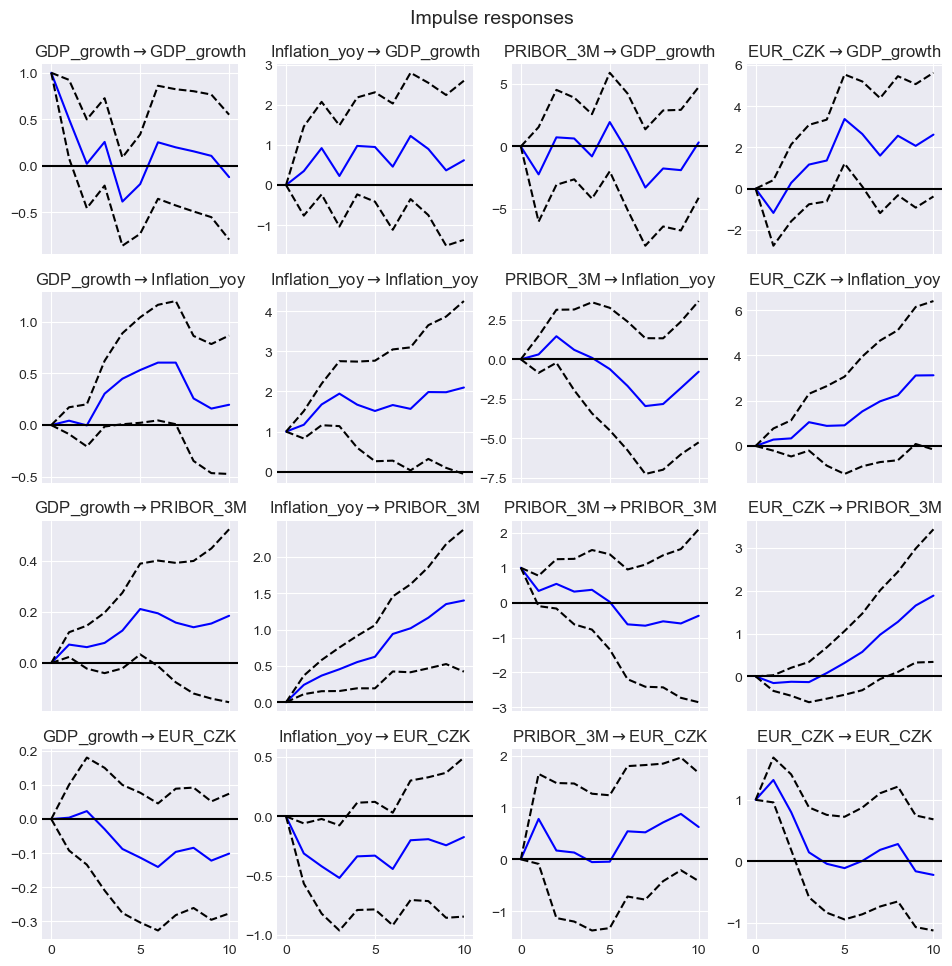

In [68]:
VAR_irf(var_data, "aic", 10)

### GDP shock
Even though none of the GDP shocks are not statistically significant, their directions overall make sense. A positive GDP shock put an upward preassure on inflation at least initially (classical New Keynesian assumption that positive GDP gap increases inflation). As a reaction to increase inflation, PRIBOR increases as well. The exchange rate appreciates since there is more demand for the CZK given higher GDP.

### Inflation shock
There is not a clear or statistically significant response of GDP growth to inflation shock. This is probably due to the fact that the GDP growth is real terms. The response of inflation to its own shock is positive and statistically significant. The response of PRIBOR is also positive and statistically significant. The response of exchange rate is negative and statistically significant If purchasing power parity holds in the long run , the nominal exchange rate should depreciate in the long run as a response to an inflation shock, even though on impact it can appreciate in response to this shock. This is a result of monetary policy tightening as a direct consequence of the increased inflation. In this case, the increase in interest rate differential relative to ECB could be more important for the exchange rate in the short run than the increase in inflation itself.

### PRIBOR increase shock
Again, there is no evidence of  a clear or statistically significant response of GDP growth to an increase in 3M PRIBOR rate. On the other hand, the effect on inflation, though statistically not significant, is after initial surge negative, which is in line with the theory. The effect on PRIBOR of it own shock is initially statistically significant and positive, but eventually turns negative as inflation decreases. The effect on exchange rate is nor unambiguous neither statistically significant. This goes against the theory and what we discussed above. However, it may depend on the resons for the increase in PRIBOR, which is not specified in the model. Also, the unconventional exchange rate policy of the CNB from 2013 until 2017 might have also played a role, resulting in a weaker than anticipated response of exchange rate in the model.

### Exchange rate depreciation shock
The reaction of GDP to a depreciation shock is positive and statistically significant. This is in line with theory as weaker exchange rate boosts the domestic product because it makes domestic goods relatively cheaper to foreign goods and thus boosts domestic and foreign demand for domestic goods. Even though the effect on inflation wasn't statistically it was unambiguously positive. This is also in line with theory as weaker exchange rate makes imports and imported inputs for domestic production more expensive and also the higher demand for domestic goods can contribute to inflation. The effect on PRIBOR is positive and statistically significant, which is probably a reaction to the inrease in inflation and GDP. The effect of exchange rate shock on itself is positive and statistically significant.

# Forecasting

In [23]:
import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')
import warnings
warnings.filterwarnings('ignore')

In [24]:
def VAR_forecast(df,info_criteria):
#Choose info_criteria from ic{‘aic’, ‘fpe’, ‘hqic’, ‘bic’, None}
  model = VAR(df)
  results = model.fit(maxlags=8, ic=info_criteria)
  lag_order = results.k_ar
  forecast_values=results.forecast(df.values[-lag_order:], 5)

  VAR_forecast_df = pd.DataFrame(forecast_values, columns=df.columns)
  VAR_forecast_df.index = pd.period_range(start=df.index[-1], periods=6, freq='Q')[1:]
  VAR_forecast_df.columns = VAR_forecast_df.columns.map(lambda x: f"{x}_VAR_forecast")

  return VAR_forecast_df

In [25]:
def data_to_quarterly(df, data_freq):
  df_quarterly=df.copy()
  df_quarterly = df_quarterly.resample(data_freq).mean()
  df_quarterly = df_quarterly.dropna()

  return df_quarterly

In [26]:
#Resample data to quarterly by averaging
df_quarterly = data_to_quarterly(df_growth, "Q")
df_quarterly

indicator_id,EUR_CZK,PRIBOR_12M,PRIBOR_3M,Inflation_yoy,GDP_growth,Industry_growth
year_month,,,,,,
2005Q1,30.014444,2.353240,2.286870,1.633333,7.896944,-0.085744
2005Q2,30.125846,1.871861,1.851616,1.566667,8.051587,0.822676
2005Q3,29.677063,1.859233,1.787269,1.866667,6.047534,0.461012
2005Q4,29.298306,2.439817,2.107548,2.400000,5.084411,0.783833
2006Q1,28.599769,2.295654,2.074781,2.833333,6.670184,0.697879
...,...,...,...,...,...,...
2022Q3,24.572667,7.491931,7.272679,17.566667,11.159286,0.087049
2022Q4,24.389333,7.374810,7.269349,15.700000,11.443834,0.065998
2023Q1,23.784333,7.235482,7.203173,16.400000,11.307186,-0.175149


In [27]:
var_list = ["GDP_growth","Inflation_yoy","PRIBOR_3M","EUR_CZK"]

# Create a dataframe to save the p-values of the ADF tests
adf_table = pd.DataFrame(index=var_list, columns=['pvalue','Integration_order'])

# Apply the ADF test to the each time series
for ts in var_list:
    adf_table.loc[var_list,'pvalue'] = adfuller(df_quarterly[f'{ts}'],autolag='aic',regression='c')[1]

for ts in var_list:
    if adf_table.loc[ts,'pvalue']<0.05:
      adf_table.loc[ts,'Integration_order'] = 0
    else:
      adf_table.loc[ts,'Integration_order'] = 1
      print("Some of the time series are not stationary. Please difference them.")

adf_table

,pvalue,Integration_order
GDP_growth,0.035711,0
Inflation_yoy,0.035711,0
PRIBOR_3M,0.035711,0
EUR_CZK,0.035711,0


In [28]:
var_data = subset_df(df_quarterly,var_list)
VAR_forecast_df=VAR_forecast(var_data,"aic")
VAR_forecast_df

indicator_id,GDP_growth_VAR_forecast,Inflation_yoy_VAR_forecast,PRIBOR_3M_VAR_forecast,EUR_CZK_VAR_forecast
2023Q4,-0.029265,7.424231,7.136110,25.221953
2024Q1,-2.030833,6.944304,7.552592,27.271266
2024Q2,-0.539418,8.157583,7.724346,27.375951
2024Q3,0.587035,11.697830,8.675721,25.236162
2024Q4,5.433690,11.712673,8.314119,24.362718


In [29]:
#Download CNB forecasts
ID_dict_forecast = {'MGDPGDPXXADJYOYPECCOPQ': 'GDP_growth_CNB_forecast', 'MCPIHINXXNAJYOYPECQ': 'Inflation_yoy_CNB_forecast',"MPIRSIRXXXRATPECNOMQ":"PRIBOR_3M_CNB_forecast" ,'MPERXMEXXXEXRVALNOMQ': 'EUR_CZK_CNB_forecast'}
IDs_forecast= ','.join(ID_dict_forecast.keys())
CNB_forecast = download_data_from_api(my_api_key, IDs_forecast)
if CNB_forecast is not None:
    print(CNB_forecast)

               indicator_id     period      value
0    MGDPGDPXXADJYOYPECCOPQ 2025-12-31   2.915441
1    MGDPGDPXXADJYOYPECCOPQ 2025-09-30   2.925344
2    MGDPGDPXXADJYOYPECCOPQ 2025-06-30   2.885463
3    MGDPGDPXXADJYOYPECCOPQ 2025-03-31   2.551609
4    MGDPGDPXXADJYOYPECCOPQ 2024-12-31   2.216939
..                      ...        ...        ...
455    MPERXMEXXXEXRVALNOMQ 1999-03-31  37.156000
456    MPERXMEXXXEXRVALNOMQ 1998-12-31  35.124000
457    MPERXMEXXXEXRVALNOMQ 1998-09-30  35.321000
458    MPERXMEXXXEXRVALNOMQ 1998-06-30  36.579000
459    MPERXMEXXXEXRVALNOMQ 1998-03-31  37.664000

[460 rows x 3 columns]


In [30]:
CNB_forecast=process_data(CNB_forecast,ID_dict_forecast)
CNB_forecast_quarterly = data_to_quarterly(CNB_forecast,'Q-DEC')
CNB_forecast_quarterly

indicator_id,Inflation_yoy_CNB_forecast,GDP_growth_CNB_forecast,EUR_CZK_CNB_forecast,PRIBOR_3M_CNB_forecast
year_month,,,,
1998Q1,13.310986,-1.123760,37.664000,16.011698
1998Q2,12.699406,-0.620105,36.579000,15.611397
1998Q3,9.525843,-0.003531,35.321000,14.180548
1998Q4,7.471488,0.364661,35.124000,11.530635
1999Q1,2.962066,0.395327,37.156000,8.083123
...,...,...,...,...
2024Q4,2.751474,2.216939,24.358460,3.543867
2025Q1,1.847490,2.551609,24.251266,3.492919
2025Q2,1.973086,2.885463,24.145991,3.478790


In [31]:
forecast_df = VAR_forecast_df.merge(CNB_forecast_quarterly, left_index=True, right_index=True, how='left')
df_merged = pd.concat([df_quarterly, forecast_df], axis=1)
df_merged

indicator_id,EUR_CZK,PRIBOR_12M,PRIBOR_3M,Inflation_yoy,GDP_growth,Industry_growth,GDP_growth_VAR_forecast,Inflation_yoy_VAR_forecast,PRIBOR_3M_VAR_forecast,EUR_CZK_VAR_forecast,Inflation_yoy_CNB_forecast,GDP_growth_CNB_forecast,EUR_CZK_CNB_forecast,PRIBOR_3M_CNB_forecast
2005Q1,30.014444,2.353240,2.286870,1.633333,7.896944,-0.085744,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005Q2,30.125846,1.871861,1.851616,1.566667,8.051587,0.822676,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005Q3,29.677063,1.859233,1.787269,1.866667,6.047534,0.461012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005Q4,29.298306,2.439817,2.107548,2.400000,5.084411,0.783833,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006Q1,28.599769,2.295654,2.074781,2.833333,6.670184,0.697879,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023Q4,NaN,NaN,NaN,NaN,NaN,NaN,-0.029265,7.424231,7.136110,25.221953,7.486953,-0.065895,24.600000,6.552746
2024Q1,NaN,NaN,NaN,NaN,NaN,NaN,-2.030833,6.944304,7.552592,27.271266,2.724428,0.267504,24.704797,5.460190
2024Q2,NaN,NaN,NaN,NaN,NaN,NaN,-0.539418,8.157583,7.724346,27.375951,2.600510,0.687400,24.643624,4.300205
2024Q3,NaN,NaN,NaN,NaN,NaN,NaN,0.587035,11.697830,8.675721,25.236162,2.235736,1.619958,24.510996,3.713199


In [32]:
for var in var_list:
  columns = [var, f"{var}_VAR_forecast",f"{var}_CNB_forecast" ]
  df_var=df_merged[columns]
  fig_var = visualize_ts(df_var,'indicator_id', f'{var} Forecasts comparison')
  fig_var.show()

In [33]:
fig_growth_fcst = visualize_ts(df_merged,'indicator_id', 'Growth Forecasts comparison')
fig_growth_fcst.show()

In [34]:
results.plot_forecast(10)

NameError: name 'results' is not defined